In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import ipopt
import matplotlib.pyplot as plt

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    portfolio_price = np.dot(x_init, cur_prices) + cash_init
    weight = 1/len(x_init) # Compute equal weight
    x_optimal_accurate = portfolio_price * weight / cur_prices
    x_optimal = np.floor(x_optimal_accurate) # Round down the number of shares to make sure we are trading integer number of shares
    transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
    cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices)
    #print(cash_optimal)
    return x_optimal, cash_optimal

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex() 
    cpx.objective.set_sense(cpx.objective.sense.minimize) # Implement Cplex minimizer
    n = len(x_init)  #n=20
    c  = [0.0] * n  #Linear part of the equation
    lb = [0.0] * n  #Lower bound
    ub = [1.0] * n  #Upper bound
    A = []
    for k in range(n):  #Create constraint matrix A
        A.append([[0],[1.0]])
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #Crreate the quadratic part of the equation
    cpx.objective.set_quadratic(Qmat)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    portfolio_price = np.dot(x_init, cur_prices) + cash_init
    weight = np.asarray(cpx.solution.get_values())
    x_optimal_accurate = portfolio_price * weight / cur_prices
    x_optimal = np.floor(x_optimal_accurate) # Round down the number of shares to make sure we are trading integer number of shares
    transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
    cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices)
    #print(cash_optimal)
    return x_optimal, cash_optimal

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex() 
    cpx.objective.set_sense(cpx.objective.sense.minimize) # Implement Cplex minimizer
    if cur_year == 2008 or 2009:
        r_rf = r_rf2008_2009
    else:
        r_rf = r_rf2015_2016
    n = len(x_init)  #n=20
    c  = [0.0] * (n+1) #Linear part of the equation, one more input added, which is the "K"
    lb = [0.0] * (n+1) #Lower bound, one more input added, which is the "K"
    A = []
    for k in range(n):
        A.append([[0,1],[mu[k]-r_rf/252,1]]) #Create constraint matrix A, risk-free rate/252 because the given risk-free rate is annually but we want to compute daily return
    A.append([[0,1],[0,-1]])
    cpx.linear_constraints.add(rhs=[1.0,0.0], senses="EE")
    var_names = ["y_%s" % i for i in range(1,n+2)]
    cpx.variables.add(obj=c, lb=lb, columns=A, names=var_names)
    Qmat = [[list(2*Q[k,:])] for k in range(n)] #Create the quadratic part of the equation, one more row and column added, with "0".
    for k in range (n):
        Qmat[k][0].append(0)
    Qmat.append([list(np.zeros(n+1))])
    Qmat = [[list(range(n+1)), Qmat[k][0]] for k in range(n+1)]
    cpx.objective.set_quadratic(Qmat)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    #print(cpx.solution.status[cpx.solution.get_status()])
    if cpx.solution.status[cpx.solution.get_status()] == 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
    else:
        y = np.asarray(cpx.solution.get_values())
        weight = y[:-1]/y[-1] #Weight is computed by y/k. The last element of input is "K"
        portfolio_price = np.dot(x_init, cur_prices) + cash_init
        x_optimal_accurate = portfolio_price * weight / cur_prices
        x_optimal = np.floor(x_optimal_accurate)  # Round down the number of shares to make sure we are trading integer number of shares
        transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
        cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices)
    #print(cash_optimal)
    return x_optimal, cash_optimal

In [6]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    class erc(object):
        def __init__(self):
            pass
        def objective(self, x): # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval
        def gradient(self, x): # The callback for calculating the gradient
            grad = np.zeros(n)
            # Insert your gradient computations here
            y = x * np.dot(Q, x)
            for i in range(n):
                grad_xi = 4 * (np.dot(Q[i],x) + x[i] * Q[i][i]) * (y[i] * n - np.sum(y))
                grad[i] = grad_xi
            # You can use finite differences to check the gradient
            return grad
        def constraints(self, x): # The callback for calculating the constraints
            return [1.0] * n  
        def jacobian(self, x): # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
        def intermediate(
                self,
                alg_mod,
                iter_count,
                obj_value,
                inf_pr,
                inf_du,
                mu,
                d_norm,
                regularization_size,
                alpha_du,
                alpha_pr,
                ls_trials
                ):
            return
            # Example for the use of the intermediate callback.
            #print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))
    n = len(x_init)
    w0 = [1.0/n] * n
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    weight, info = nlp.solve(w0)
    #print('Constraint sum(w) = 1? :', np.allclose(np.sum(weight),1))
    var_ERC = np.dot(weight, np.dot(Q, weight))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (weight * np.dot(Q, weight)) / std_ERC
    #print('Sum of risk contribution = portfolio std? :', np.allclose(np.sum(RC_ERC), std_ERC))
    #with np.printoptions(precision=6, suppress=True):
        #print("Risk contributions of assets in the ERC portfolio:\n{0}".format(RC_ERC))
    portfolio_price = np.dot(x_init, cur_prices) + cash_init
    x_optimal_accurate = portfolio_price * weight / cur_prices
    x_optimal = np.floor(x_optimal_accurate)
    transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
    cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices)
    return x_optimal, cash_optimal

In [7]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    class erc(object):
        def __init__(self):
            pass
        def objective(self, x): # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval
        def gradient(self, x): # The callback for calculating the gradient
            grad = np.zeros(n)
            # Insert your gradient computations here
            y = x * np.dot(Q, x)
            for i in range(n):
                grad_xi = 4 * (np.dot(Q[i],x) + x[i] * Q[i][i]) * (y[i] * n - np.sum(y))
                grad[i] = grad_xi
            # You can use finite differences to check the gradient
            return grad
        def constraints(self, x): # The callback for calculating the constraints
            return [1.0] * n  
        def jacobian(self, x): # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
        def intermediate(
                self,
                alg_mod,
                iter_count,
                obj_value,
                inf_pr,
                inf_du,
                mu,
                d_norm,
                regularization_size,
                alpha_du,
                alpha_pr,
                ls_trials
                ):
            return
            # Example for the use of the intermediate callback.
            #print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))
    if cur_year == 2008 or 2009:
        r_rf = r_rf2008_2009
    else:
        r_rf = r_rf2015_2016
    n = len(x_init)
    w0 = [1.0/n] * n
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    weight, info = nlp.solve(w0)
    #print('Constraint sum(w) = 1? :', np.allclose(np.sum(weight),1))
    var_ERC = np.dot(weight, np.dot(Q, weight))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (weight * np.dot(Q, weight)) / std_ERC
    #print('Sum of risk contribution = portfolio std? :', np.allclose(np.sum(RC_ERC), std_ERC))
    #with np.printoptions(precision=6, suppress=True):
        #print("Risk contributions of assets in the ERC portfolio:\n{0}".format(RC_ERC))
    portfolio_price = np.dot(x_init, cur_prices) + cash_init #2 times
    x_optimal_accurate = portfolio_price * weight / cur_prices #2 times
    x_optimal = np.floor(x_optimal_accurate) #2 times
    transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
    interest_fee = init_value * r_rf/6
    cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices) - interest_fee
    return x_optimal, cash_optimal

In [8]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    def min_variance_solver(x_init, Q):
        cpx = cplex.Cplex() 
        cpx.objective.set_sense(cpx.objective.sense.minimize)
        n = len(x_init)  #n=20
        c  = [0.0] * n  #Linear part of the equation
        lb = [0.0] * n  #Lower bound
        ub = [1.0] * n  #Upper bound
        A = []
        for k in range(n):  #Create constraint matrix A
            A.append([[0],[1.0]])
        cpx.linear_constraints.add(rhs=[1.0], senses="E")
        var_names = ["w_%s" % i for i in range(1,n+1)]
        cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
        Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #Create the quadratic part of the equation
        cpx.objective.set_quadratic(Qmat)
        cpx.set_results_stream(None)
        cpx.set_warning_stream(None)
        cpx.solve()
        weight = np.array(cpx.solution.get_values())
        return weight
    Portf_Retn = 5 * np.dot(mu, min_variance_solver(x_init, Q))
    n = len(x_init)
    w0 = [1.0/n] * n
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd  = rob_init
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize) 
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    w_rMV = cpx.solution.get_values()
    w_rMV = np.array(w_rMV)
    w_rMV[w_rMV<1e-6] = 0
    w_rMV = w_rMV / np.sum(w_rMV)
    portfolio_price = np.dot(x_init, cur_prices) + cash_init
    x_optimal_accurate = portfolio_price * w_rMV / cur_prices
    x_optimal = np.floor(x_optimal_accurate)
    transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
    cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices)
    return x_optimal, cash_optimal

In [9]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [10]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [11]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

In [12]:
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [13]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [14]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

In [15]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000002.12



In [16]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [17]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

In [18]:
# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf2015_2016 = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

In [19]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  #comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

In [20]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight_list_all = []

In [21]:
for period in range(1, N_periods+1): #period = 1-12
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    weight_list = []
   # Execute portfolio selection strategies
    for strategy in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            if strategy == 5:
                curr_positions = init_positions * 2
            else:
                curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
        if cash[strategy, period-1] < 0: # Check if the cash is negative. If so, we apply the following technique to fix it
            portfolio_price_rebalanced = np.dot(x[strategy, period-1], cur_prices) + cash[strategy, period-1]
            portfolio_price_initial = np.dot(curr_positions, cur_prices) + curr_cash
            weight = x[strategy, period-1] * cur_prices / portfolio_price_rebalanced #Compute the weight, based on the output of different strategy
            x_delta_accurate = cash[strategy, period-1] * weight / cur_prices
            x_delta = np.floor(x_delta_accurate) #We round down the number of shares to make sure they are integer numbers and also make sure we always trade with "Fewer" number of shares in case that the cash become negative again. 
            x_adjusted = x[strategy, period-1] + x_delta #The adjusted number of shares we should trade.
            transaction_fee = np.dot(np.absolute(x_adjusted - curr_positions), cur_prices)*0.005
            if strategy == 5:
                interest_fee = init_value * r_rf2015_2016/6
                cash[strategy, period-1] = portfolio_price_initial - transaction_fee - np.dot(x_adjusted, cur_prices) - interest_fee
            else:
                cash[strategy, period-1] = portfolio_price_initial - transaction_fee - np.dot(x_adjusted, cur_prices)
            x[strategy, period-1] = x_adjusted
        
      # Compute portfolio value
        if strategy == 5:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1] - init_value
        else:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        #print(cash[strategy, period-1])
        w = (x[strategy, period-1] * cur_prices) / portf_value[strategy][day_ind_start][0]
        weight_list.append(w)
    weight_list_all.append(weight_list)
    
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992870.53, value end = $ 1020359.86
  Strategy "Mininum Variance Portfolio", value begin = $ 991448.22, value end = $ 1016705.73
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.77, value end = $ 1008186.98
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 992745.82, value end = $ 1018819.69
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 981342.09, value end = $ 1033439.71
  Strategy "Robust Optimization Portfolio", value begin = $ 991269.65, value end = $ 996436.62

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1031099.28, value end = $ 1011540.17
  Strategy "Mininum Variance Portfolio", value begin =

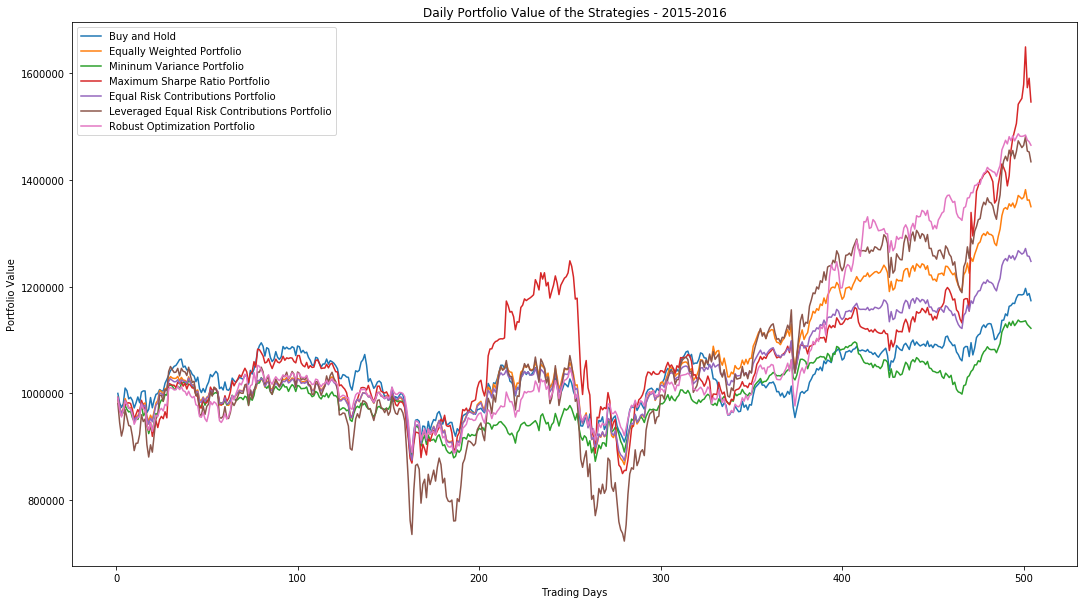

In [22]:
# Plot results
###################### Insert your code here ############################
#This chart illustrates the daily value of the portfolio for each strategy.

trading_days = list(range(1,N_days+1))
plt.figure(figsize=(18,10))
for i in range(N_strat):
    plt.plot(trading_days ,portf_value[i],label=strategy_names[i])
plt.legend()
plt.title('Daily Portfolio Value of the Strategies - 2015-2016')
plt.ylabel('Portfolio Value')
plt.xlabel('Trading Days')
plt.show()

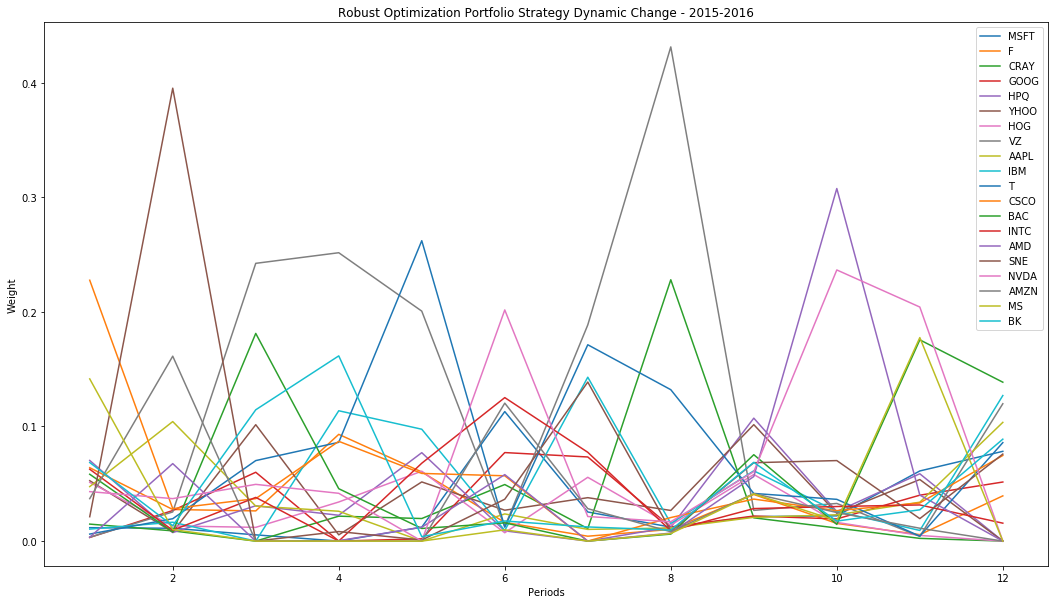

In [23]:
#This chart illustrates the dynamic changes of weights of each assets for strategy 7.
periods = list(range(1,N_periods+1))
stock_name = list(df.columns)[1:]
weight_stra7 = [weight_list_all[i][6] for i in range(0,12)]
plt.figure(figsize=(18,10))
for i in range(N): #N=20
    plt.plot(periods, [weight_stra7[k][i] for k in range(0,12)], label=stock_name[i])
plt.legend()
plt.title('Robust Optimization Portfolio Strategy Dynamic Change - 2015-2016')
plt.ylabel('Weight')
plt.xlabel('Periods')
plt.show()

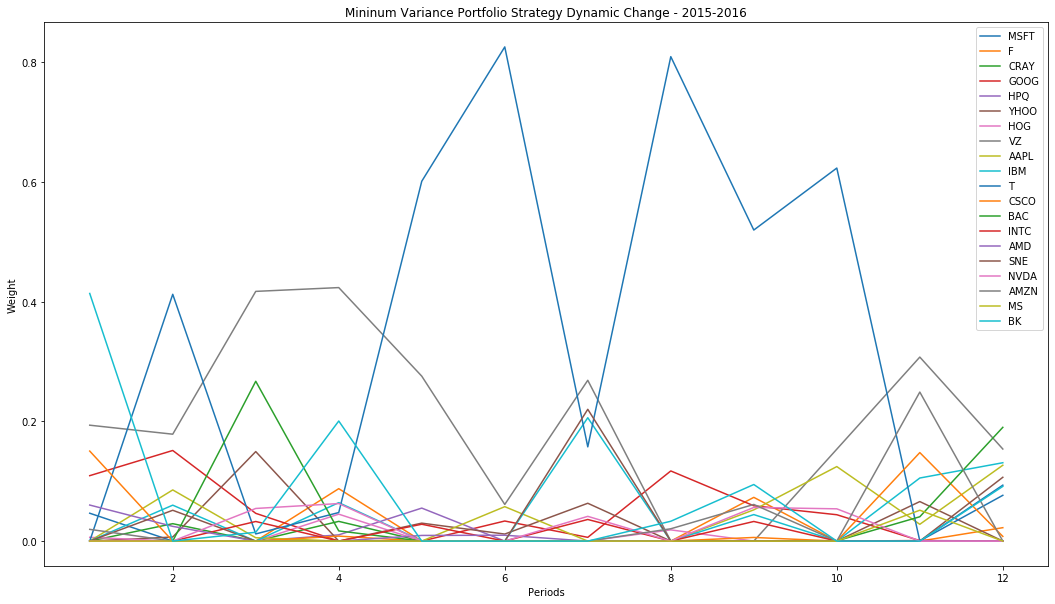

In [24]:
#Strategy 3
periods = list(range(1,N_periods+1))
stock_name = list(df.columns)[1:]
weight_stra3 = [weight_list_all[i][2] for i in range(0,12)]
plt.figure(figsize=(18,10))
for i in range(N): #N=20
    plt.plot(periods, [weight_stra3[k][i] for k in range(0,12)], label=stock_name[i])
plt.legend()
plt.title('Mininum Variance Portfolio Strategy Dynamic Change - 2015-2016')
plt.ylabel('Weight')
plt.xlabel('Periods')
plt.show()

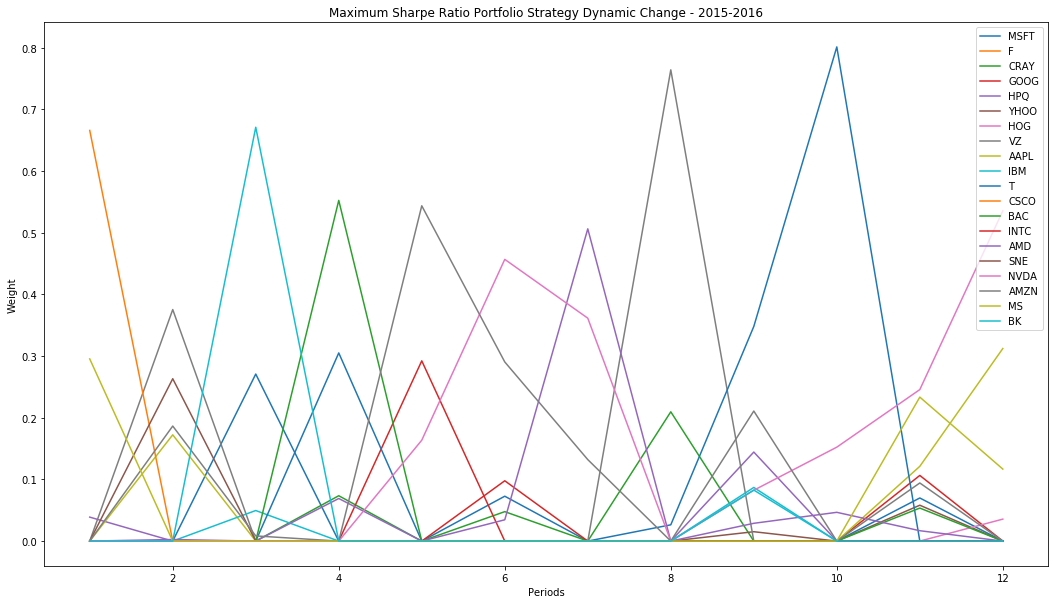

In [25]:
#Strategy 4
weight_stra4 = [weight_list_all[i][3] for i in range(0,12)]
plt.figure(figsize=(18,10))
for i in range(N): #N=20
    plt.plot(periods, [weight_stra4[k][i] for k in range(0,12)], label=stock_name[i])
plt.legend()
plt.title('Maximum Sharpe Ratio Portfolio Strategy Dynamic Change - 2015-2016')
plt.ylabel('Weight')
plt.xlabel('Periods')
plt.show()

In [26]:
# Input file
input_file_prices_crisis = 'Daily_closing_prices20082009.csv'
# Read data into a dataframe
df_crisis = pd.read_csv(input_file_prices_crisis)

In [27]:
df_crisis

,Date,MSFT,F,CRAY,GOOG,HPQ,YHOO,HOG,VZ,AAPL,...,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
0,11/1/2007,37.060001,8.50,5.77,350.292023,23.387829,30.219999,49.450001,41.766872,26.777143,...,40.459999,32.180000,45.709999,26.500000,12.80,49.099998,35.380001,87.650002,62.419998,46.990002
1,11/2/2007,37.060001,8.95,6.46,354.296997,23.796549,31.110001,49.459999,41.430798,26.838572,...,40.419998,32.509998,45.110001,26.799999,13.17,49.540001,36.740002,85.980003,58.900002,47.200001
2,11/5/2007,36.730000,8.67,6.13,361.470123,23.860126,31.360001,48.459999,40.908012,26.597143,...,40.040001,33.080002,44.450001,26.840000,13.42,48.639999,36.740002,84.370003,55.590000,47.419998
3,11/6/2007,36.410000,8.63,6.02,369.509979,24.255222,29.930000,48.700001,40.833328,27.398571,...,40.040001,34.080002,45.560001,27.490000,13.43,48.849998,37.900002,87.269997,54.509998,48.279999
4,11/7/2007,35.520000,8.24,6.05,365.101501,23.542234,27.629999,48.119999,40.235859,26.614286,...,38.660000,32.750000,43.310001,26.900000,13.01,47.930000,36.099998,87.040001,51.189999,45.770000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,12/24/2009,31.000000,10.13,6.25,308.085236,24.009991,16.719999,25.900000,31.287977,29.862858,...,28.100000,23.959999,15.250000,20.330000,9.91,29.309999,18.090000,138.470001,29.600000,27.760000
542,12/28/2009,31.170000,10.20,6.25,310.272034,23.960037,16.879999,25.450001,31.409903,30.230000,...,28.330000,24.080000,15.290000,20.299999,9.83,29.580000,17.799999,139.309998,29.290001,27.660000
543,12/29/2009,31.389999,10.11,6.20,308.543518,23.873751,16.920000,25.440001,31.353630,29.871429,...,28.340000,24.100000,15.120000,20.400000,9.75,29.350000,18.020000,139.410004,29.430000,27.629999
544,12/30/2009,30.959999,9.99,6.28,310.202271,24.037239,16.980000,25.500000,31.344250,30.234285,...,28.320000,24.180000,15.070000,20.590000,9.72,29.299999,18.670000,136.490005,29.490000,28.020000


In [28]:
dates_array = np.array(list(df_crisis['Date'].apply(convert_date_to_array)))
data_prices = df_crisis.iloc[:, 1:].to_numpy()
dates = np.array(df_crisis['Date'])

day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

init_value = np.dot(data_prices[0,:], init_positions)

w_init = (data_prices[0,:] * init_positions) / init_value

N_periods = 6*len(np.unique(dates_array[:,0]))
N = len(df.columns)-1
N_days = len(dates)

strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']

N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight_list_all = []

In [29]:
for period in range(1, N_periods+1): #period = 1-12
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    weight_list = []
   # Execute portfolio selection strategies
    for strategy in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            if strategy == 5:
                curr_positions = init_positions * 2
            else:
                curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
        if cash[strategy, period-1] < 0: # Check if the cash is negative. If so, we apply the following technique to fix it
            portfolio_price_rebalanced = np.dot(x[strategy, period-1], cur_prices) + cash[strategy, period-1]
            portfolio_price_initial = np.dot(curr_positions, cur_prices) + curr_cash
            weight = x[strategy, period-1] * cur_prices / portfolio_price_rebalanced #Compute the weight, based on the output of different strategy
            x_delta_accurate = cash[strategy, period-1] * weight / cur_prices
            x_delta = np.floor(x_delta_accurate) #We round down the number of shares to make sure they are integer numbers and also make sure we always trade with "Fewer" number of shares in case that the cash become negative again. 
            x_adjusted = x[strategy, period-1] + x_delta #The adjusted number of shares we should trade.
            transaction_fee = np.dot(np.absolute(x_adjusted - curr_positions), cur_prices)*0.005
            if strategy == 5:
                interest_fee = init_value * r_rf2008_2009/6
                cash[strategy, period-1] = portfolio_price_initial - transaction_fee - np.dot(x_adjusted, cur_prices) - interest_fee
            else:
                cash[strategy, period-1] = portfolio_price_initial - transaction_fee - np.dot(x_adjusted, cur_prices)
            x[strategy, period-1] = x_adjusted
        
      # Compute portfolio value
        if strategy == 5:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1] - init_value
        else:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        #print(cash[strategy, period-1])
        w = (x[strategy, period-1] * cur_prices) / portf_value[strategy][day_ind_start][0]
        weight_list.append(w)
    weight_list_all.append(weight_list)
    
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Period 1: start date 1/2/2008, end date 2/29/2008
  Strategy "Buy and Hold", value begin = $ 548247.97, value end = $ 465217.72
  Strategy "Equally Weighted Portfolio", value begin = $ 544326.12, value end = $ 470183.89
  Strategy "Mininum Variance Portfolio", value begin = $ 543915.02, value end = $ 461793.66
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 542793.38, value end = $ 473593.26
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 544293.32, value end = $ 471869.06
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 536237.07, value end = $ 391839.96
  Strategy "Robust Optimization Portfolio", value begin = $ 544629.14, value end = $ 471845.36

Period 2: start date 3/3/2008, end date 4/30/2008
  Strategy "Buy and Hold", value begin = $ 462553.95, value end = $ 511257.48
  Strategy "Equally Weighted Portfolio", value begin = $ 463855.35, value end = $ 510348.31
  Strategy "Mininum Variance Portfolio", value begin = $ 454294.1

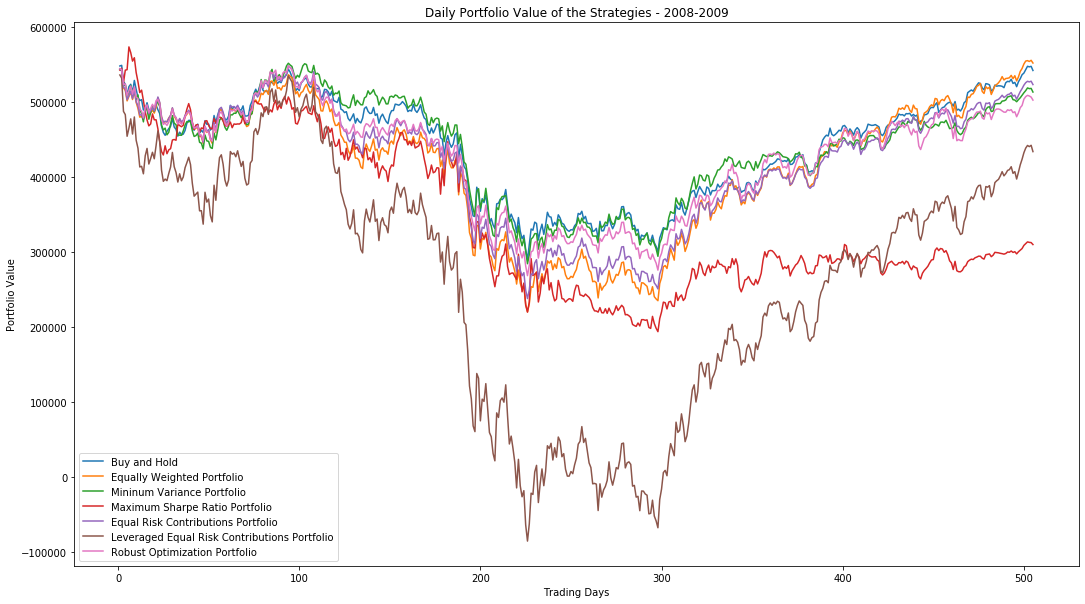

In [30]:
trading_days = list(range(1,N_days+1))
plt.figure(figsize=(18,10))
for i in range(N_strat):
    plt.plot(trading_days ,portf_value[i],label=strategy_names[i])
plt.legend()
plt.title('Daily Portfolio Value of the Strategies - 2008-2009')
plt.ylabel('Portfolio Value')
plt.xlabel('Trading Days')
plt.show()

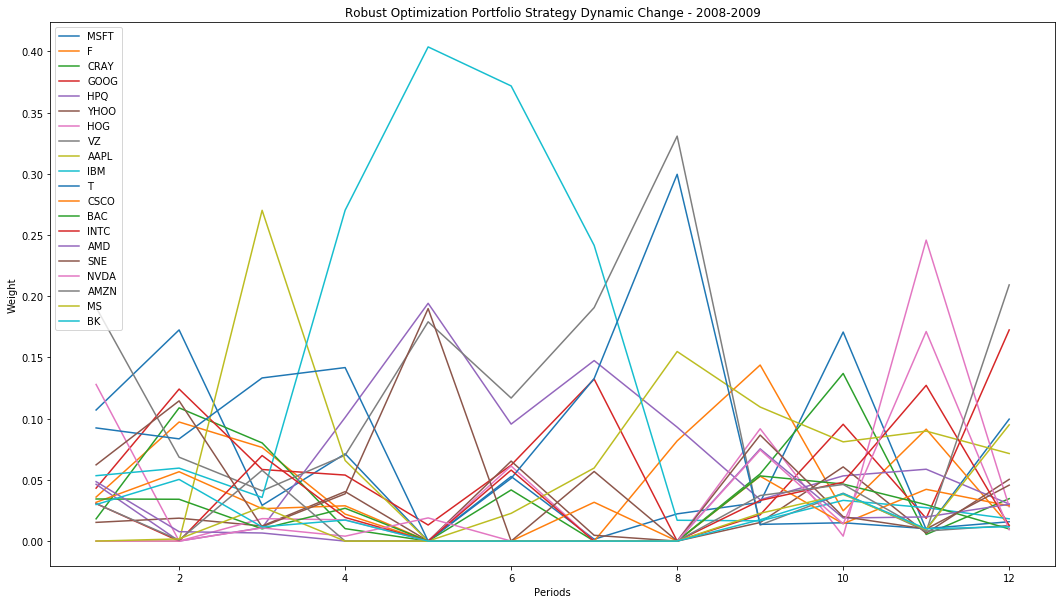

In [31]:
#Strategy 7
periods = list(range(1,N_periods+1))
stock_name = list(df.columns)[1:]
weight_stra7 = [weight_list_all[i][6] for i in range(0,12)]
plt.figure(figsize=(18,10))
for i in range(N): #N=20
    plt.plot(periods, [weight_stra7[k][i] for k in range(0,12)], label=stock_name[i])
plt.legend()
plt.title('Robust Optimization Portfolio Strategy Dynamic Change - 2008-2009')
plt.ylabel('Weight')
plt.xlabel('Periods')
plt.show()

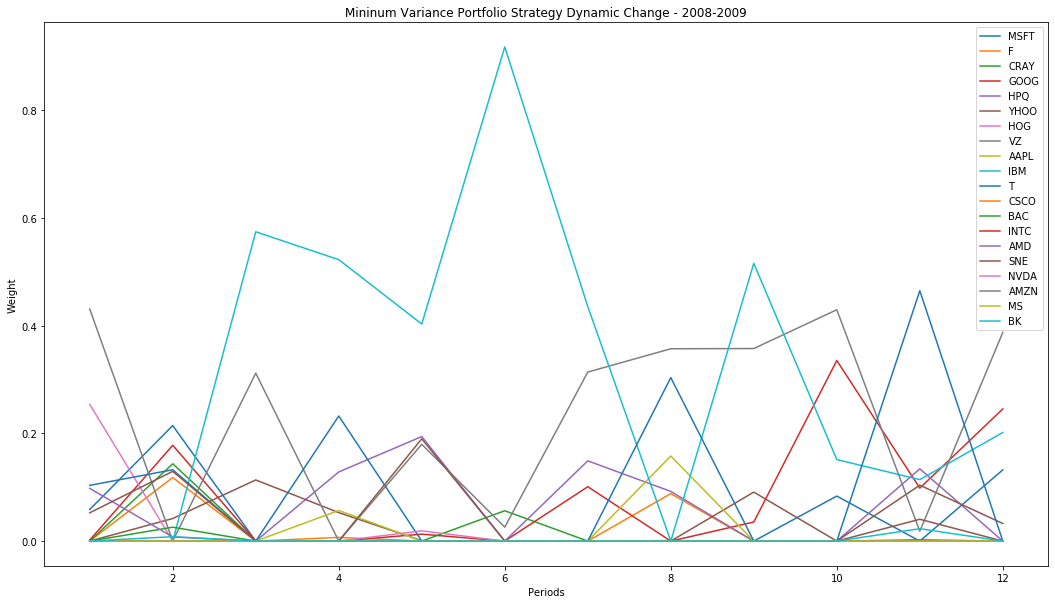

In [32]:
#Strategy 3
periods = list(range(1,N_periods+1))
stock_name = list(df.columns)[1:]
weight_stra3 = [weight_list_all[i][2] for i in range(0,12)]
plt.figure(figsize=(18,10))
for i in range(N): #N=20
    plt.plot(periods, [weight_stra3[k][i] for k in range(0,12)], label=stock_name[i])
plt.legend()
plt.title('Mininum Variance Portfolio Strategy Dynamic Change - 2008-2009')
plt.ylabel('Weight')
plt.xlabel('Periods')
plt.show()

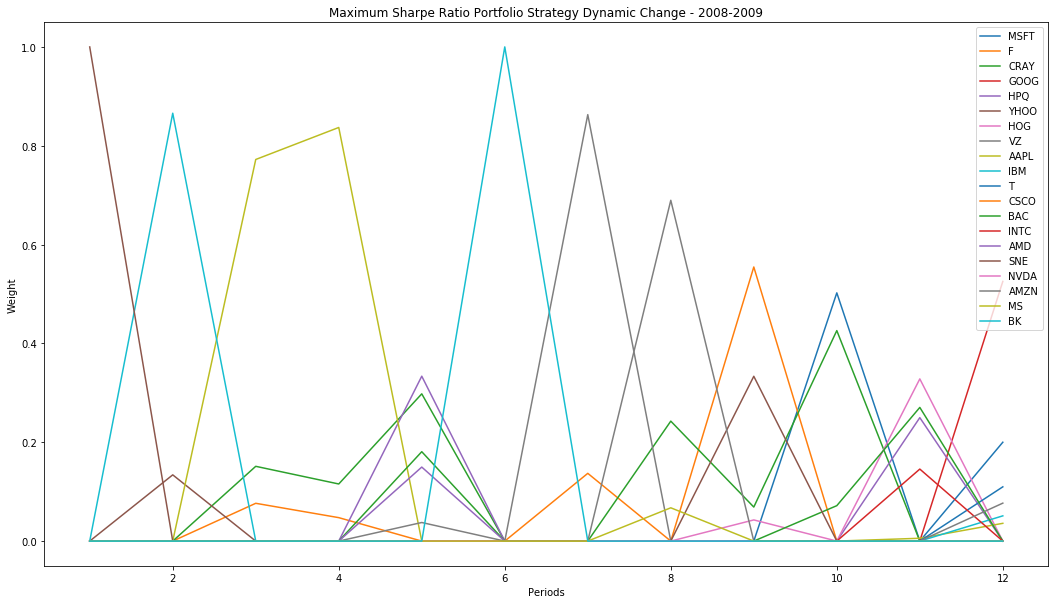

In [33]:
#Strategy 4
weight_stra4 = [weight_list_all[i][3] for i in range(0,12)]
plt.figure(figsize=(18,10))
for i in range(N): #N=20
    plt.plot(periods, [weight_stra4[k][i] for k in range(0,12)], label=stock_name[i])
plt.legend()
plt.title('Maximum Sharpe Ratio Portfolio Strategy Dynamic Change - 2008-2009')
plt.ylabel('Weight')
plt.xlabel('Periods')
plt.show()